In [70]:
import pandas as pd
import numpy as np

# Load your dataset
df_loc = 'salaries.csv'
df = pd.read_csv(df_loc)  # Replace with your CSV file path

# Select features and target
X = df[['experience_level', 'employment_type', 'job_title',
        'remote_ratio', 'company_location', 'company_size']]

y = df['salary_in_usd']
# y = np.log(df["salary_in_usd"])



In [71]:
y

0        170000
1        110000
2        170000
3        110000
4        143000
          ...  
73143    412000
73144    151000
73145    105000
73146    100000
73147     94665
Name: salary_in_usd, Length: 73148, dtype: int64

In [72]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split

# Custom wrapper for log-transforming target
class LogTargetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_model):
        self.base_model = base_model
    
    def fit(self, X, y):
        # Log-transform the target variable
        self.y_log = np.log(y)
        self.base_model.fit(X, self.y_log)
        return self
    
    def predict(self, X):
        # Make predictions and revert log transformation
        log_predictions = self.base_model.predict(X)
        return np.exp(log_predictions)  # Convert predictions back to original scale
    
    def score(self, X, y):
        from sklearn.metrics import r2_score
        y_pred = self.predict(X)
        return r2_score(y, y_pred)
    
experience_order = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
X['experience_level'] = X['experience_level'].map(experience_order)

# Define categorical columns
categorical_features = ['employment_type', 'job_title', 'company_location', 'company_size']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')  # remote_ratio will pass through as numeric

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

/var/folders/2g/k4yj_mp50q9378f62ks9_d740000gn/T/ipykernel_21707/2728692207.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['experience_level'] = X['experience_level'].map(experience_order)


In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogTargetRegressor(
        RandomForestRegressor(n_estimators=100, random_state=39)))
])

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R² scores:", cv_scores)
print("Average R² score:", np.mean(cv_scores).round(3))

Cross-validation R² scores: [0.27956295 0.28866664 0.28114689 0.27676983 0.27974212]
Average R² score: 0.281


In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

linreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogTargetRegressor(LinearRegression()))
])

# Use 5-fold cross-validation (you can change cv= to any number of folds)
cv_scores = cross_val_score(linreg_model, X_train, y_train, cv=5, scoring='r2')

print("Cross-validation R² scores:", cv_scores)
print("Average R² score:", np.mean(cv_scores).round(3))

Cross-validation R² scores: [0.26887916 0.27331718 0.26381094 0.26413052 0.26809785]
Average R² score: 0.268


In [62]:
from xgboost import XGBRegressor

xg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogTargetRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1)))
])
# Use 5-fold cross-validation (you can change cv= to any number of folds)
cv_scores = cross_val_score(xg_model, X_train, y_train, cv=5, scoring='r2')

print("Cross-validation R² scores:", cv_scores)
print("Average R² score:", np.mean(cv_scores).round(3))

Cross-validation R² scores: [0.27534533 0.2764501  0.26847678 0.26955122 0.27111322]
Average R² score: 0.272


In [77]:
# Fit the model
rf_model.fit(X_train, y_train)
# Evaluate
# score = rf_model.score(X_test, y_test)
# print(f"R^2 score on test set: {score:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['employment_type',
                                                   'job_title',
                                                   'company_location',
                                                   'company_size'])])),
                ('regressor',
                 LogTargetRegressor(base_model=RandomForestRegressor(random_state=39)))])

In [81]:
# Custom input
new_input = pd.DataFrame([{
    'experience_level': 'SE',
    'employment_type': 'FT',
    'job_title': 'Data Scientist',
    'remote_ratio': 100,
    'company_location': 'US',
    'company_size': 'L'
}])

new_input['experience_level'] = new_input['experience_level'].map(experience_order)

predicted_salary = rf_model.predict(new_input)
print(f"Estimated salary (USD): ${predicted_salary[0]}")

Estimated salary (USD): $164465.8520038241


In [32]:
predicted_salary

array([12.06083117])

In [56]:
rf_model.fit(X_train[:100], y_train[:100])
print(rf_model.predict(new_input))

[166608.44961246]


In [85]:
import pandas as pd

# Get predictions
predictions = rf_model.predict(X_test.iloc[:8])
actuals = y_test.iloc[:8].values

# Create a DataFrame for display
comparison = pd.DataFrame({
    'Predicted Salary (USD)': [f"${pred:.2f}" for pred in predictions],
    'Actual Salary (USD)': [f"${actual:.2f}" for actual in actuals]
})

print(comparison)

  Predicted Salary (USD) Actual Salary (USD)
0             $124374.73           $83000.00
1             $124983.26          $126802.00
2             $137058.03          $154100.00
3             $191380.57          $289400.00
4             $137640.06          $180000.00
5             $137640.06          $140000.00
6              $47415.18           $93750.00
7             $171753.25          $237500.00


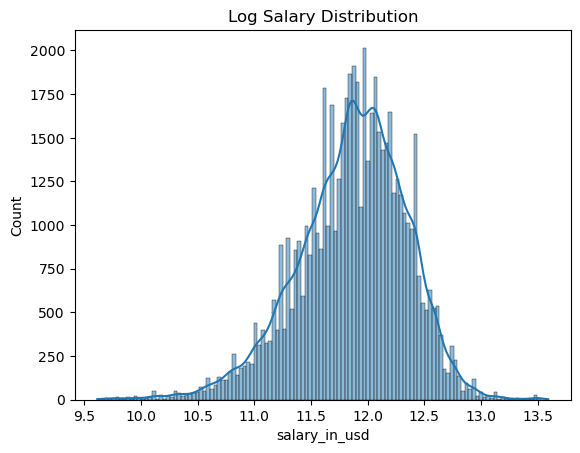

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(np.log(y_train), kde=True)
plt.title("Log Salary Distribution")
plt.show()